# Random forest estimator

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import regex as re


import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

%precision 4


'%.4f'

## Loading the dataset
The dataset is divided in files depending on the CE efficiency $ \alpha $ and the metallicity $ Z $ of the two stars. All the data are loaded into a pandas dataframe containing also the two parameters.


In [3]:

alpha = [0.5, 1, 3, 5] # CE efficiency
Z = [2e-4, 4e-4, 8e-4, 1.2e-3, 1.6e-3, 2e-3, 4e-3, 6e-3, 8e-3, 1.2e-2, 1.6e-2, 2e-2]  #Metallicity value

data = [] #Data list 

sim_data = pd.DataFrame({'alpha':[], 'Z':[], 'MtotZAMS':[], 'num_mergers':[]})
#Appending all the values in a single big dataframe

index = 0
for a in alpha:
  for m in Z:
    # The simulation data first row contains the MtotZAMS and the number of merger for each alpha and metallicity 
    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', sep=' ', nrows = 1, header=0) 
    sim_data.loc[index] = [a, m, df.iloc[0,0], df.iloc[0,1]]  #Adding the row to the sim_data df
    index = index + 1 

    df = pd.read_csv(f'stable_MT_vs_CE/A{a}/MTCE_BBHs_{m}.txt', header=2, sep= ' ')     # Simulation data
    df['alpha'],df['Z'] = a, m                                 #Adding the alpha and Z parameter in the table
    
    data.append(df)

data = pd.concat(data)
# Cleaning the column names using regex: sub substitutes with '' all strings that matches the first regex
# that starts from col, has any (.) char repeated any times (*) until :, and (|) from / any char, any times to the end of line $
data.columns = [re.sub('col.*:|/.*$', '', name) for name in data.columns]
print('Data columns: \n ', data.columns.values)


Data columns: 
  ['ID' 'm1ZAMS' 'm2ZAMS' 'm1rem' 'm2rem' 'm1rem+m2rem' 'delay_time' 'sma'
 'ecc' 'kick' 'kick' 'cmu1' 'cmu2' 'v1x' 'v1y' 'v1z' 'v2x' 'v2y' 'v2z'
 'time_SN1' 'time_SN2' 'CE' 'alpha' 'Z']


In [4]:
CE_data = data.query('CE == True')
MT_data = data.query('CE == False')


print(f'There are {CE_data.shape[0]} BBHs evolving from common envelope, and {MT_data.shape[0]} BBHs evolving from mass transfer')


There are 2551001 BBHs evolving from common envelope, and 412581 BBHs evolving from mass transfer


MAchine learnig part, where the features to analize are described

In [5]:
data_to_ML = data.copy()

features_to_analize = ['m1ZAMS', 'm2ZAMS','m1rem','m2rem','delay_time','sma', 'ecc', 'alpha', 'Z']#,'kick','kick', 'cmu1', 'cmu2', 'v1x', 'v1y', 'v1z', 'v2x', 'v2y', 'v2z','time_SN1','time_SN2' ]

x = data_to_ML[features_to_analize]
y = data_to_ML['CE']

# split data into training and test set
# for now: 10% of data as training set
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.9, random_state=100)


Random forest classifier

In [6]:
# initialise random forest classifier
# using n_jobs=-1 saves quite a bit of time (~80s with vs ~430s without)
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# train random forest
# let's time this for fun
ts = time.time()
clf.fit(X_train, y_train)
print("Training time: %.2f s"%(time.time()-ts))

# evaluate training & test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)


Training time: 42.45 s
Training accuracy:  1.0
Test accuracy:  0.997928183009751


Importance of each parameter


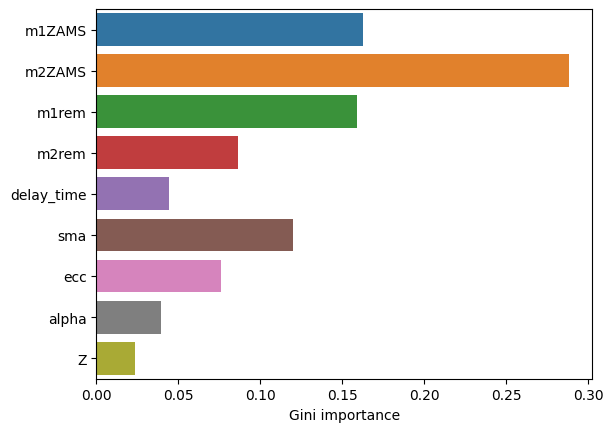

In [7]:
# save params + importances to dataframe
importances = pd.DataFrame(zip(clf.feature_names_in_, clf.feature_importances_),
                           columns=["param", "gini"])

# sort importances
#importances = importances.sort_values(by="gini", ascending= False)

# plot importances
fig, ax = plt.subplots()
sns.barplot(y='param', x='gini', data=importances, ax=ax)
#ax.tick_params(axis='x', rotation=90) #for params on x and gini on y
ax.set_ylabel('')
ax.set_xlabel('Gini importance')
plt.show()


With this part of code I'm trying to isolate the most important features by dropping one of them at a time and judging how the score changes

In [8]:
def perform_random_forest(x, y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.9, random_state=100)
  # initialise random forest classifier
  # using n_jobs=-1 saves quite a bit of time (~80s with vs ~430s without)
  clf = RandomForestClassifier(random_state=0, n_jobs=-1)

  # train random forest
  # let's time this for fun
  ts = time.time()
  clf.fit(X_train, y_train)
  training_time = (time.time()-ts)

  # evaluate training & test accuracy
  train_acc = clf.score(X_train, y_train)
  test_acc = clf.score(X_test, y_test)
  
  return train_acc, test_acc, training_time


data_to_ML = data[features_to_analize].copy()
y = data['CE'].copy()

for f in features_to_analize:
  
  train_acc, test_acc, training_time = perform_random_forest(data_to_ML.drop(columns=f), y)

  print(f'Excluding {f}: training score {100*train_acc}%, test score {100*test_acc}, time {training_time}')



Excluding m1ZAMS: training score 100.0%, test score 99.75180187340845, time 31.0309956073761
Excluding m2ZAMS: training score 99.99966257026975%, test score 99.42910681667531, time 30.410611867904663
Excluding m1rem: training score 100.0%, test score 99.60674469035972, time 30.850096702575684
Excluding m2rem: training score 100.0%, test score 99.75202682639328, time 28.861884117126465
Excluding delay_time: training score 100.0%, test score 99.79761729798471, time 28.001099824905396
Excluding sma: training score 100.0%, test score 99.79435547970475, time 29.31255865097046
Excluding ecc: training score 100.0%, test score 99.78603221926618, time 28.6031653881073
Excluding alpha: training score 100.0%, test score 99.74385353461128, time 30.822285413742065
Excluding Z: training score 100.0%, test score 99.76421177973803, time 31.170711517333984


Doing the same but with a linear perceptron, so also linear combinations of features can be studied (in which case a PCA could be used to restrict the data)

In [10]:
def perform_perceptron(x, y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=100)
  # initialise random forest classifier
  # using n_jobs=-1 saves quite a bit of time (~80s with vs ~430s without)
  clf = Perceptron(random_state=100, n_jobs=-1)

  # train random forest
  # let's time this for fun
  ts = time.time()
  clf.fit(X_train, y_train)
  training_time = (time.time()-ts)

  # evaluate training & test accuracy
  train_acc = clf.score(X_train, y_train)
  test_acc = clf.score(X_test, y_test)
  
  return train_acc, test_acc, training_time


data_to_ML = data[features_to_analize].copy()
y = data['CE'].copy()

#With all feature
train_acc, test_acc, training_time = perform_perceptron(data_to_ML, y)
print(f'With all fetaures: training score {100*train_acc}%, test score {100*test_acc}, time {training_time}')

for f in features_to_analize:
  
  train_acc, test_acc, training_time = perform_perceptron(data_to_ML.drop(columns=f), y)

  print(f'Excluding {f}: training score {100*train_acc}%, test score {100*test_acc}, time {training_time}')


With all fetaures: training score 94.20669406294905%, test score 94.20080551116486, time 22.67610192298889
Excluding m1ZAMS: training score 93.37922675537615%, test score 93.39178508184685, time 34.89707899093628
Excluding m2ZAMS: training score 64.30206515900132%, test score 64.34155401027944, time 10.058410406112671
Excluding m1rem: training score 88.43088947336692%, test score 88.42415129788796, time 22.78215980529785
Excluding m2rem: training score 94.2921762228223%, test score 94.29758022718438, time 33.47227954864502
Excluding delay_time: training score 97.67978922798812%, test score 97.67767675895132, time 3.8295838832855225
Excluding sma: training score 90.04636732313966%, test score 90.03004470263033, time 27.4143226146698
Excluding ecc: training score 93.70149449809824%, test score 93.69466159892886, time 33.34003210067749
Excluding alpha: training score 83.89957015970766%, test score 83.87371506932148, time 98.29842281341553
Excluding Z: training score 93.55028105634354%, te

Testing which feature has the biggest importance for each value of Z and alpha

In [18]:
#For all values of metallicity and alpha

clf = RandomForestClassifier(random_state=0, n_jobs=-1)

importance_list = []

for a in alpha:
  for z in Z:
   
    data_to_ML = data.query(f'alpha == {a} and Z == {z}')
    x = data_to_ML[features_to_analize]
    y = data_to_ML['CE']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=100)
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    importances[-1] = z 
    importances[-2] = a 
    importance_list.append(importances)

importance = pd.DataFrame(importance_list, columns=features_to_analize)

importance    


,m1ZAMS,m2ZAMS,m1rem,m2rem,delay_time,sma,ecc,alpha,Z
0,0.026226,0.111685,0.016583,0.037973,0.462352,0.266746,0.078435,0.5,0.0002
1,0.052203,0.104368,0.030248,0.050909,0.450317,0.224476,0.087479,0.5,0.0004
2,0.103546,0.090273,0.062487,0.055747,0.376291,0.233200,0.078458,0.5,0.0008
3,0.136633,0.103849,0.077960,0.065191,0.354558,0.201377,0.060432,0.5,0.0012
4,0.146045,0.144897,0.094466,0.095099,0.302215,0.165230,0.052048,0.5,0.0016
5,0.175595,0.121155,0.113852,0.079477,0.268937,0.178122,0.062861,0.5,0.0020
6,0.120456,0.204696,0.106949,0.091126,0.053026,0.159715,0.264031,0.5,0.0040
7,0.095766,0.242647,0.164594,0.156736,0.190902,0.077545,0.071810,0.5,0.0060
8,0.061541,0.014769,0.043686,0.011365,0.085728,0.357931,0.424981,0.5,0.0080
9,0.094059,0.079098,0.031324,0.009197,0.071061,0.282946,0.432314,0.5,0.0120


<Axes: ylabel='alpha'>

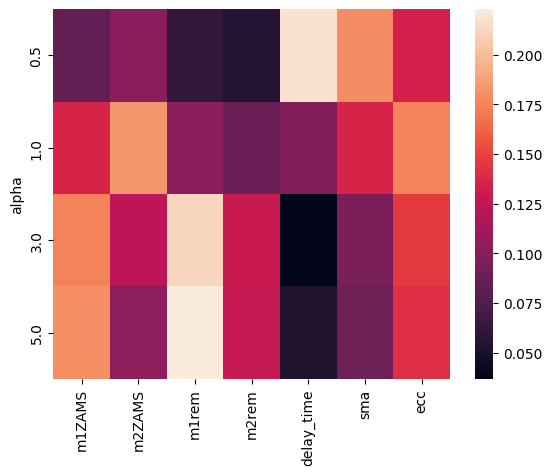

In [40]:
df = importance.drop(columns='Z')
df = df.groupby('alpha').aggregate('mean')
sns.heatmap(df)


<Axes: ylabel='Z'>

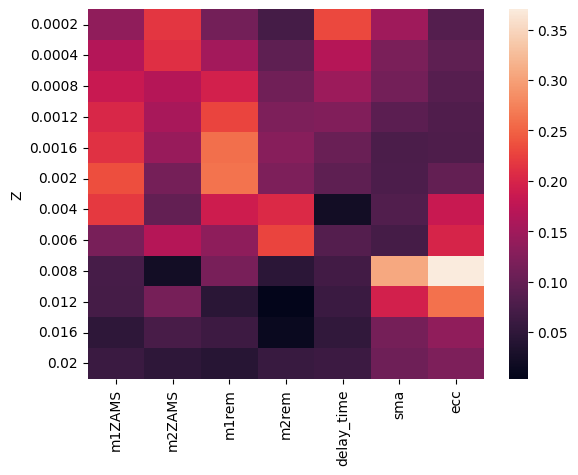

In [41]:
df = importance.drop(columns='alpha')
df = df.groupby('Z').aggregate('mean')
sns.heatmap(df)
